# Regression via classification

In [168]:
%matplotlib inline

import ipytest.magics
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.linear_model
import pytest

__file__ = 'RegressionViaClassification.ipynb'

In [147]:
x, y = sklearn.datasets.make_regression(n_samples=10_000, n_features=10, n_informative=5, noise=0.5)

extended_edges = np.percentile(y, np.linspace(0, 100, num=20, endpoint=True))
edges = extended_edges[1:-1]

## Via Multinomial Classification

Model $p(y \in I_i)$ directly.

In [223]:
# TODO: Use splines to smoothly interpolate between the different bins
class ClassifyingRegressor:
    def __init__(self, est, edges=None, bins=None):
        self.est = est
        self.edges = edges
        self.bins = bins
        
        if (edges is None) == (bins is None):
            raise ValueError("either bins or edges have to be given")
    
    def fit(self, x, y):
        self.edges_ = self.find_quantile_edges(y, self.bins) if self.edges is None else self.edges
        self.bins_ = len(self.edges_) + 1 if self.bins is None else self.bins
        
        one_hot_y = self.create_one_hot_encoding(y, self.edges_)
        assert np.all(one_hot_y.sum(axis=1) == 1)
        
        self.centers_ = self.calculate_bin_means(y, one_hot_y)
        
        order, classes = np.nonzero(one_hot_y)
        classes = classes[np.argsort(order)]
        
        self.est.fit(x, classes)
        return self
    
    def predict_proba(self, x):
        return self.est.predict_proba(x)
    
    def predict(self, x):
        proba = self.predict_proba(x)
        return np.sum(proba * self.centers_[None, :], axis=1)
    
    @staticmethod
    def create_one_hot_encoding(y, edges):
        y = np.asarray(y)
        edges = np.asarray(edges)
        
        result = np.zeros((len(y), len(edges) + 1), dtype=np.int8)
        
        for i in range(len(edges) - 1):
            result[:, i + 1] = (edges[i] <= y) * (y < edges[i + 1])
        
        result[:, 0] = y < edges[0]
        result[:, -1] = edges[-1] <= y
        
        return result

    @staticmethod
    def find_quantile_edges(y, bins):
        all_edges = np.percentile(y, np.linspace(0, 100, num=bins + 1, endpoint=True))
        return all_edges[1:-1]
    
    
    @staticmethod
    def calculate_bin_means(y, one_hot_encoding):
        y = np.asarray(y)
        one_hot_encoding = np.asarray(one_hot_encoding)
        return (
            np.sum(y[:, None] * one_hot_encoding, axis=0) / 
            np.maximum(1, np.sum(one_hot_encoding, axis=0))
        )

In [224]:
%%run_pytest[clean] -qq


def test_find_quantiles():
    actual = ClassifyingRegressor.find_quantile_edges(np.linspace(0, 100, 100), 10) 
    expected = np.linspace(0, 100, 11)[1:-1]
    assert actual == pytest.approx(expected)
    
    
def test_create_one_hot_encoding():
    values = [0, 1, 2, 3, 4, 5]
    edges = [1.5, 3.5, 4.5]
    expected = np.array([
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ], dtype='int8')

    actual = ClassifyingRegressor.create_one_hot_encoding(values, edges)

    assert actual == pytest.approx(expected)
    
    
def test_calculate_bin_means():
    values = [0, 1, 2, 3, 4, 5]
    edges = [1.5, 3.5, 4.5]
    expected = np.array([0.5, 2.5, 4. , 5. ])

    one_hot_encoding = ClassifyingRegressor.create_one_hot_encoding(values, edges)
    actual = ClassifyingRegressor.calculate_bin_means(values, one_hot_encoding)

    assert actual == pytest.approx(expected)

...                                                                                                                                                                       [100%]


In [221]:
est = ClassifyingRegressor(
    sklearn.linear_model.LogisticRegression(
        multi_class='multinomial', solver='lbfgs', C=100.0,
    ),
    bins=25,
)
est.fit(x, y)
y_pred = est.predict(x)

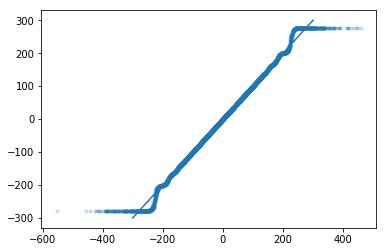

In [222]:
plt.scatter(y, y_pred, marker='.', alpha=0.2)
plt.plot([-300, +300], [-300, +300])

## Via Repeated Binary Classification

Note: this is a specific decomposition. Any binary decomposition works.

$$
    \log p(y \in I_i) = \sum_{j \leq i} \log q(y \gt t_j) + \log (1 - q(y \gt t_{i +1}))
$$

Introduce pseudo-targets 

$$
\mathcal{Y}_i = \mathcal{I}\left[ y \in I_i \right]
$$

TODO: update the math...